## Clean up old intersections file to sum collisions, injuries, and fatalities

In [4]:
import geopandas as gp
import numpy as np
import pandas as pd

In [6]:
intersections = pd.read_csv('../osm/osm_w_collisions/nodes/intersection_w_collisions.csv')
# intersections.rename(columns={'Num_Collis':'Num_Collisions', 'Num_Injuri': 'Num_Injuries',
#                               'Num_Fatali':'Num_Fatalities'}, inplace=True)
intersections['Num_Collisions'] = intersections[['Total_Injuries', 'Total_Fatalaties']].apply(np.sum, axis=1)
intersections.head()

,Unnamed: 0,osmid,Total_Injuries,Total_Fatalaties,lon,lat,Num_Collisions
0,0,42860546,0.0,0.0,-73.940452,40.743627,0.0
1,1,42467330,2.0,0.0,-73.933676,40.655156,2.0
2,2,42467331,1.0,0.0,-73.932706,40.655216,1.0
3,3,42467333,1.0,0.0,-73.931772,40.655273,1.0
4,4,42467334,23.0,0.0,-73.930768,40.655336,23.0


In [9]:
intersections[['Num_Collisions','Total_Injuries', 'Total_Fatalaties']].describe()

,Num_Collisions,Total_Injuries,Total_Fatalaties
count,55161.000000,55161.000000,55161.000000
mean,1.631080,1.610830,0.020250
std,3.729886,3.690463,0.159562
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000
max,81.000000,81.000000,6.000000


In [10]:
intersections[['Num_Collisions','Total_Injuries', 'Total_Fatalaties']].sum()

Num_Collisions      89972.0
Total_Injuries      88855.0
Total_Fatalaties     1117.0
dtype: float64

In [0]:
# all num_* fields are filled with 0
intersections.head(2)

,NODEID,VIntersect,Num_Collisions,Num_Injuries,Num_Fatalities,NODEID_1,FREQUENCY,SUM_NUMBER,SUM_NUMB_1,FIRST_From,FREQUENCY_,SUM_NUMB_2,SUM_NUMB_3,LAST_To_no,FREQUENCY1,SUM_NUMB_4,SUM_NUMB_5,geometry
0,13,None,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,POINT (913523.7852251232 123479.0677957535)
1,14,None,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,POINT (913553.9593760371 123788.9185403585)


In [0]:
# sum corresponding fields
intersections['Num_Collisions'] = intersections.FREQUENCY + intersections.FREQUENCY_ + intersections.FREQUENCY1
intersections['Num_Injuries'] = intersections.SUM_NUMBER + intersections.SUM_NUMB_2 + intersections.SUM_NUMB_4
intersections['Num_Fatalities'] = intersections.SUM_NUMB_1 + intersections.SUM_NUMB_3 + intersections.SUM_NUMB_5

In [0]:
# don't want to look at virtual intersections
intersections = intersections[intersections.VIntersect != 'VirtualIntersection'].reset_index(drop=True)

In [0]:
intersections[['NODEID', 'VIntersect', 'Num_Collisions', 'Num_Injuries',
       'Num_Fatalities','geometry']].to_file('../Data/intersections_updated/intersections.shp')

## Summary Statistics

In [0]:
collisions = gp.read_file('../Data/collisions/collisions.shp')

In [0]:
# number of accidents at intersections vs on road
at_intersection = collisions.close_to_i.sum()
on_roads = len(collisions) - at_intersection

print(at_intersection, on_roads)

61898 11270


In [0]:
# number of intersections with collisions
with_collisions = intersections[intersections.Num_Collisions > 0].FREQUENCY.count()
without_collision = len(intersections) - with_collisions

print( without_collision, with_collisions)

37334 20606


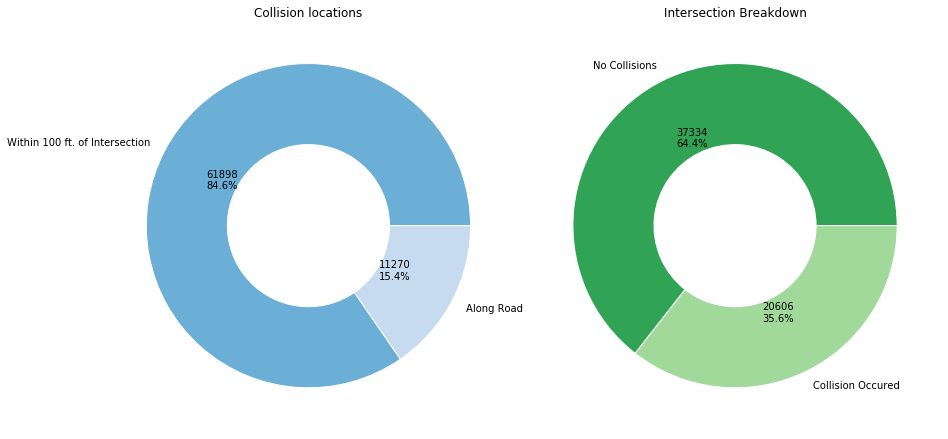

In [0]:
fig = plt.figure(figsize=(12,6))
size = 0.5
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:d}\n{:1.1f}%".format(absolute, pct)

#intersection vs on road
ax = plt.subplot(121)
size = 0.5
vals = np.array([at_intersection, on_roads])

cmap = plt.get_cmap("tab20c")
inner_colors = cmap(np.array([1, 3]))
labels=['Within 100 ft. of Intersection', 'Along Road']
ax.pie(vals, radius=1, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), autopct=lambda pct: func(pct,vals), labels=labels)
ax.set(aspect="equal", title='Collision locations')


#collision vs no collision
ax = plt.subplot(122)
size = 0.5
vals = np.array([without_collision, with_collisions])

cmap = plt.get_cmap("tab20c")
inner_colors = cmap(np.array([8, 10]))
labels=['No Collisions','Collision Occured']
ax.pie(vals, radius=1, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), autopct=lambda pct: func(pct,vals), labels=labels)
ax.set(aspect="equal", title='Intersection Breakdown')
# ax.legend()
plt.tight_layout()
plt.savefig('Output tables/piecharts.png')

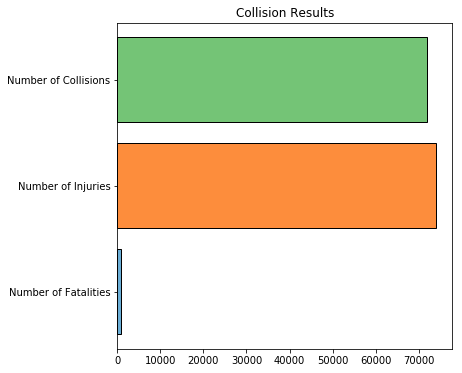

<Figure size 432x288 with 0 Axes>

In [0]:
## number of injuries, number of deaths, number of collisions
plt.figure(figsize=(6,6))
labels=['Number of Fatalities', 'Number of Injuries', 'Number of Collisions']
plt.title('Collision Results')
vals = np.array([intersections.Num_Fatalities.sum(),intersections.Num_Injuries.sum(),intersections.Num_Collisions.sum()])
plt.barh(range(3), vals, color=cmap(np.arange(3)*4+1), edgecolor='k')
# plt.legend()
plt.yticks(range(3), labels)
plt.show()
plt.savefig('Output tables/Injury_Fatality_Counts.png')

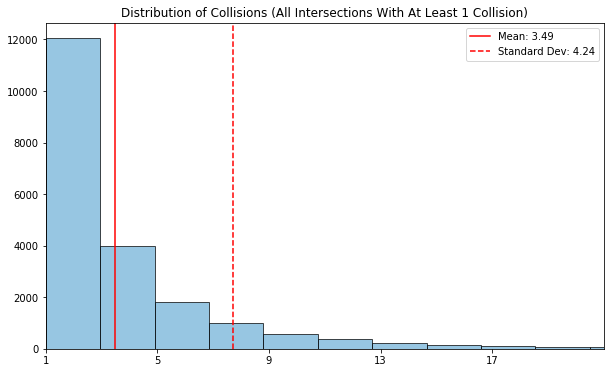

<Figure size 432x288 with 0 Axes>

In [0]:
# look at distribution of collisions at intersections
collision_summary = intersections[intersections.Num_Collisions > 0].describe().Num_Collisions
mean = collision_summary[1]
stddev1, stddev2 = mean-collision_summary[2],mean+collision_summary[2]

plt.figure(figsize=(10,6))

plt.xlim(1,21)
plt.title('Distribution of Collisions (All Intersections With At Least 1 Collision)')

plt.hist(intersections[intersections.Num_Collisions > 0].Num_Collisions, bins=40,
        alpha=0.7, edgecolor='k', color=cmap(1))

# plot mean and standard devs
plt.axvline(mean, color='r', label='Mean: {0:.2f}'.format(mean))
plt.axvline(stddev1, color='r', linestyle='--', label='Standard Dev: {0:.2f}'.format(collision_summary[2]))
plt.axvline(stddev2, color='r', linestyle='--')
plt.xticks(range(1,21,4))

plt.legend()
plt.show()
plt.savefig('Output tables/CollisionDist.png')